In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Plot inline
% matplotlib inline

## Fitting tuning curves with gradient descent

The firing rates $y_j$ of neuron $j$ can be modeled as a Poisson random variable. 

$$
y_j = \text{Poisson}(\lambda_j)
$$

We will drop the subscript $j$ for convenience of notation and figure out how to fir the tuning curves of a given neuron $j$.

The mean $\lambda$ is given by the von Mises tuning model as follows.

$$
\lambda = b + g\exp\Big(\kappa \cos(x - \mu)\Big)
$$

Given a set of observations $(x_i, y_i)$, to identify the parameters $\Theta = \left\{\mu, \kappa, g, b\right\}$ we use gradient descent on the loss function $J$, specified by the negative Poisson log-likelihood,

$$
J = -\log\mathcal{L} = \sum_{i} \lambda_i - y_i \log \lambda_i
$$

Taking the gradients, we get:

$$
\frac{\partial J}{\partial \mu} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \kappa \sin(x_i - \mu)\bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial \kappa} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \cos(x_i - \mu)\bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial g} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial b} = \sum_{i} \bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

## Decoding the feature from population activity

Under the same Poisson firing rate model for each neuron, whose mean is specified by the von Mises tuning curve, as above, we can decode the stimulus $\hat{x}$ that is most likely to have produced the observed population activity $Y = \left\{y_j, j = 1, 2, \dots \text{n_neurons}\right\}$.

We will assume that the neurons are conditionally independent given the tuning parameters $\Theta$. Thus the likelihood of observing the population activity $Y$ is given by

$$
P(Y | \Theta) = \prod_j P(y_j | \Theta)
$$

As before, the loss function for the decoder is given by the negative Poisson log-likelihood:

$$
J = -\log\mathcal{L} = \sum_j \lambda_j - y_j \log \lambda_j
$$

where 
$$
\lambda_j = b_j + g_j \exp\Big(\kappa_j \cos(x - \mu_j) \Big)
$$

To minimize this loss function with gradient descent, we need to take the gradient of $J$ with respect to $x$

$$
\frac{\partial J}{\partial x} = -\sum_{j} g_j \exp\Big(\kappa_j \cos(x - \mu_j)\Big) \kappa_j \sin(x - \mu_j) \bigg(1 - \frac{y_j}{\lambda_j}\bigg)
$$


In [2]:
import sys
sys.path.append('../neuropop')
from neuropop import NeuroPop

### Create a NeuroPop object

In [3]:
n_neurons = 5
pop = NeuroPop(n_neurons, tunemodel='georgopulos', fit_k=False, n_repeats=5)

### Simulate a population of neurons

In [4]:
# Simulate a population of neurons
n_samples = 500
x, Y, mu, k0, k, g, b = pop.simulate(n_samples=500, noise_mean=1.0)

### Fit the tuning curves with gradient descent

In [5]:
pop.fit(x, Y)

### Predict the population activity with the fit tuning curves

In [6]:
Yhat = pop.predict(x)

### Plot the simulated and fit tuning curves

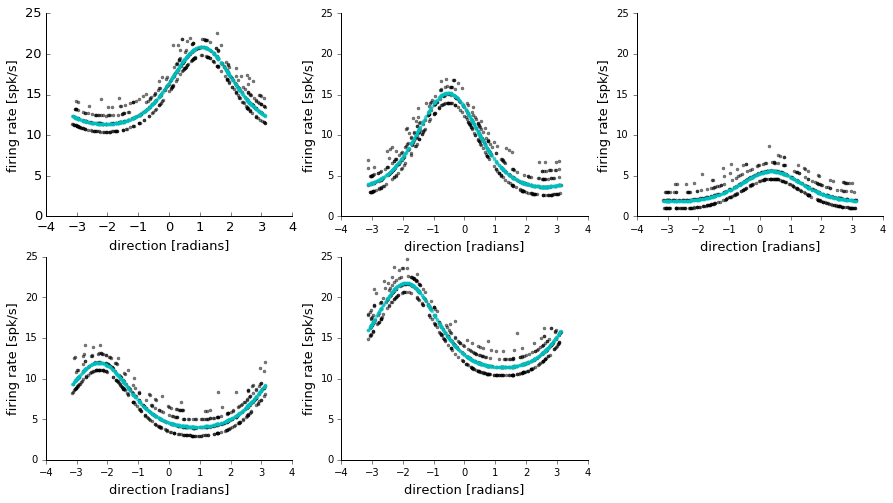

In [7]:
plt.figure(figsize=[15,8])

for neuron in range(n_neurons):
    plt.subplot(2,3,neuron+1)
    pop.display(x, Y[:, neuron], Yhat[:, neuron])

plt.show()

### Decode feature from the population activity

In [8]:
xhat = pop.decode(Y)

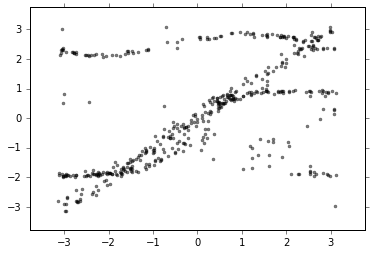

In [9]:
plt.plot(x, xhat, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.show()

### Quantify decoding performance

In [10]:
from scipy import stats
def circ_corr(alpha1, alpha2):
    alpha1_bar = stats.circmean(alpha1)
    alpha2_bar = stats.circmean(alpha2)
    num = np.sum(np.sin(alpha1 - alpha1_bar) * np.sin(alpha2 - alpha2_bar));
    den = np.sqrt(np.sum(np.sin(alpha1 - alpha1_bar) ** 2) * np.sum(np.sin(alpha2 - alpha2_bar) ** 2));
    rho = num / den
    return rho


In [11]:
circ_corr(x, xhat)

-0.62670735778420184

In [12]:
print x[:5]
print xhat[:5]

[-2.52366127 -0.49569541  2.87700477  0.20838363  1.20559946]
[-1.77250257 -1.16296846  0.75920285  2.6839813   0.82593075]
